In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [82]:
from pylab import rcParams
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['figure.figsize'] = 20, 15
rcParams['font.size'] = 24
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'k'

%matplotlib inline

In [ ]:
!python -m pip install --upgrade pip
!pip install -U numpy
!pip install -U gensim

In [12]:
import os
import sys
import gzip
import json

import nltk
from nltk import clean_html
import random
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()
from gensim.models import Word2Vec
from gensim import corpora, models, similarities


In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
# import our intents file
import json
def getdata(path):
    g = open(path,'r')
    for l in g:
        yield eval(l)
intents = list(getdata('datasets/QA_Video_Games.json'))

In [6]:
stop_words = nltk.corpus.stopwords.words('english') + [
    '.',    
    ',',
    '#',
    '@',
    '$',
    '%',
    '&',
    '--',
    '\'s',
    '?',
    ')',
    '(',
    '\'',
    '\'\'',
    '\'re',
    '"',
    '-',
    '}',
    '{',
    '!',
    u'—',
    ''
]

In [68]:
qa_df = pd.DataFrame(columns=['asin', 'q_type', 'q_text', 'a_text', 'a_help'])
# loop through each question in our intents
index = 0
for intent in intents:
    asin = intent['asin']
    qObj = {}   
    for question in intent['questions']:
        aObj = {}
        aObj['helpful'] = -1
        for answer in question['answers']:
            #print (answer['helpful'])
            t = answer['helpful']
            if (t[0]+t[1] > aObj['helpful']):
                aObj['helpful'] = t[0]+t[1]
                aObj['a_text'] = answer['answerText']
        qa_df.loc[index] = [asin, question['questionType'], question['questionText'], aObj['a_text'], aObj['helpful']]
        index = index+1
qa_df.head()    


,asin,q_type,q_text,a_text,a_help
0,B0000512IE,open-ended,Can I use these with Window 8/8.1?,"Yes, you will need to go to their website to d...",4
1,B0000512IE,open-ended,Could this be adapted to be used in racing gam...,I googled the question and found many forums o...,0
2,B0000512IE,open-ended,How far are the pedals apart? i.e. the spacing...,4 inches. They are also at an awkward angle wh...,4
3,B0000512IE,open-ended,Is there any adjustment in sensitivity of the ...,I don't think so. My son and husband use this...,2
4,B0000512IE,yes/no,"does anyone use them for Star Citizen, and if ...",Yep. They're a bit small and certainly take so...,2


##### How many questions raised for each products?

In [69]:
grouped_by_asin = qa_df.groupby('asin')
grouped_by_asin = pd.DataFrame({'asin': grouped_by_asin.size().index, 'count': grouped_by_asin.size().values})
grouped_by_asin.sort_values(by='count', ascending=False)
grouped_by_asin['count'].unique()

array([ 4, 10,  5,  3,  9,  7,  8,  6,  1,  2], dtype=int64)

##### There are at most 10 questions and at least 1 questions for all the products, let's check the products numbers for each number of question

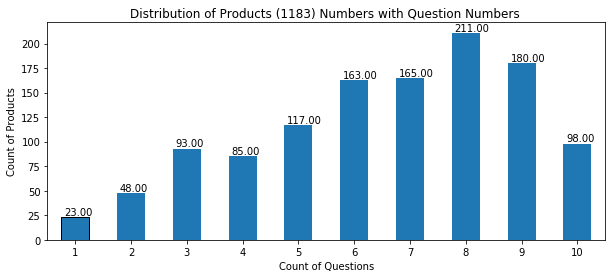

In [70]:
df_asin_count = grouped_by_asin.groupby('count')
df_asin_count = pd.DataFrame({'Questions': df_asin_count.size().index, 'Products': df_asin_count.size().values})
df_asin_count.sort_values(by='Questions')
df_asin_count.head()

ax = df_asin_count.plot(kind='bar', x='Questions', y='Products', rot=0, edgecolor='k', legend=False, figsize=(10,4))
plt.xlabel('Count of Questions'); 
plt.ylabel('Count of Products');
plt.title('Distribution of Products (%d) Numbers with Question Numbers '%(len(grouped_by_asin)))
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2-0.2, b.y1+2))

##### Show the questions and answers length distribution

The shortest and longest questions are 2 and 2478
The shortest and longest answers are 1 and 7026


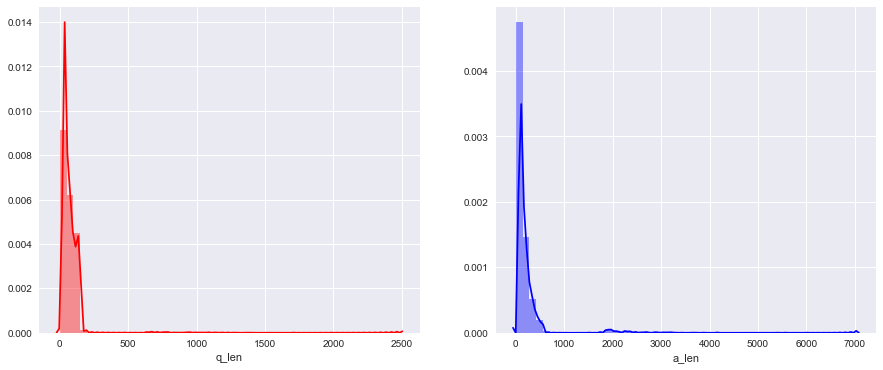

In [120]:
qa_df['q_len'] = qa_df[['q_text']].applymap(len)
qa_df['a_len'] = qa_df[['a_text']].applymap(len)
print('The shortest and longest questions are {} and {}'.format(qa_df['q_len'].min(), qa_df['q_len'].max()))
print('The shortest and longest answers are {} and {}'.format(qa_df['a_len'].min(), qa_df['a_len'].max()))

sns.set(rc={'figure.figsize':(15, 6)})

q_ax = plt.subplot(1, 2, 1)
sns.distplot(qa_df['q_len'], color='r', ax=q_ax)
a_ax = plt.subplot(1, 2, 2)
sns.distplot(qa_df['a_len'], color='b', ax=a_ax);

plt.show()

In [121]:
def sentence_words_mapper(s):
    tmpWords = nltk.word_tokenize(s)
    return [w.lower() for w in tmpWords if w.lower() not in stop_words]
    
# quesiton is like ['B0000512IE', 'May I use this in racing games also?']
def find_answer(q):
    k_df = qa_df[qa_df.asin == q[0]]
    k_df['q_text'] = k_df[['q_text']].applymap(sentence_words_mapper)
    
    q_base = k_df.q_text.values.tolist()
    dictionary = corpora.Dictionary(q_base)
    corpus = [dictionary.doc2bow(text) for text in q_base]
    lsi_model = models.LsiModel(corpus, id2word=dictionary)
    q_words = sentence_words_mapper(q[1])
    vec_bow = dictionary.doc2bow(q_words)
    vec_lsi = lsi_model[vec_bow] 
    index = similarities.MatrixSimilarity(lsi_model[corpus]) 
    sims = index[vec_lsi]
    a_index = -1
    max_prob = 0
    for i in range(len(sims)):
        if (sims[i] > max_prob):
            max_prob = sims[i]
            a_index = i

    return (k_df.loc[a_index].a_text)

In [122]:
print (find_answer(['B0000512IE', 'May I use this in racing games also?']))

I googled the question and found many forums of users using both the CH yoke and pedals for racing games. So yes they can be use for racing. - Dave


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
words = []
# loop through each question in our intents
for intent in intents:
    for question in intent['questions']:
        # tokenize each word in the sentence
        w = nltk.word_tokenize(question['questionText'])
        # add to our words list
        words.extend(w)
        
        for answer in question['answers']:
            w = nltk.word_tokenize(answer['answerText'])
            words.extend(w)
            
# stem and lower each word and remove duplicates
for i in range(len(words)):
    words[i] = words[i].replace("'", "");
words = [stemmer.stem(w.lower()) for w in words if w.lower() not in stop_words]

words = sorted(list(set(words)))

print (len(words), "unique stemmed words")

18327 unique stemmed words


In [16]:
model = Word2Vec(words, sg=1, size=100,  window=5,  min_count=5,  negative=3, sample=0.001, hs=1, workers=5)

In [17]:
model.save('datasets/Game.bin')

In [18]:
question_seqs = []
answer_seqs = []

In [19]:
# 有的参数没用
max_w = 50
float_size = 4
word_vector_dict = {}
word_vec_dim = 100
max_seq_len = 8
word_set = {}

In [20]:
input_file = open('datasets/Game.bin', "rb")

In [21]:
def deuni(text):
    deuni_text = []
    for i in text:
        i = i.decode("utf-8")
        deuni_text.append(i)
    return deuni_text

In [22]:
# answers是question-answer pair
questions = []
answers1 =[]

for i in range(len(answers)):
    questions.append(answers[i][0]) 
    answers1.append(answers[i][1])

In [24]:
questions[0]

['Can', 'I', 'use', 'these', 'with', 'Window', '', '']

In [25]:
answers1[0]

['Yes',
 '',
 'you',
 'will',
 'need',
 'to',
 'go',
 'to',
 'their',
 'website',
 'to',
 'download',
 'version',
 '',
 'or',
 'above',
 'of',
 'the',
 'CH',
 'Control',
 'Manager',
 'program',
 '',
 'then',
 'you',
 'll',
 'be',
 'all',
 'set',
 '',
 'Find',
 'it',
 'here',
 '',
 'http',
 '',
 'wwwchproductscomDownloadsandCommunityphp']

In [32]:
fo = open("datasets/QA_pair.txt", "w")

In [49]:
for i in range(int(len(questions)/10)):
    for w_q in questions[i]:
        w_q = w_q.lower()
        fo.write(w_q+" ")
        
    fo.write('|')
    
    for w_a in answers1[i]:
        w_a = w_a.lower()
        fo.write(w_a+" ")
    
    fo.write('\n')
            
fo.close()

UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f621' in position 0: character maps to <undefined>

In [21]:
fo = open("/data/QA/QA_pair.txt", "r")
print  len(fo.readlines())

28893


In [22]:
#load vector
model_w2v = Word2Vec.load('/data/QA/Game.bin')
word_vector=model_w2v.wv
#word_vocab = model_w2v.vocabulary
word_vector_dict = word_vector.vocab

In [23]:
def init_seq(input_file):
    """读取切好词的文本文件，加载全部词序列
    """
    file_object = open(input_file, 'r')
    vocab_dict = {}
    while True:
        question_seq = []
        answer_seq = []
        line = file_object.readline()
        if line:
            line_pair = line.split('|')
            line_question = line_pair[0]
            line_answer = line_pair[1]
            for word in line_question.split(' '):
                if word_vector_dict.has_key(word):
                    question_seq.append(word_vector[word])
            for word in line_answer.decode('utf-8').split(' '):
                if word_vector_dict.has_key(word):
                    answer_seq.append(word_vector[word])
        else:
            break
        question_seqs.append(question_seq)
        answer_seqs.append(answer_seq)
    file_object.close()

In [24]:
import sys
import math
import tflearn
import tensorflow as tf
from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import rnn
import chardet
import numpy as np
import struct

In [25]:
# get the vectorized question & answer 
question_seqs=[]
answer_seqs=[]
init_seq('/data/QA/QA_pair.txt')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [26]:
def get_max_seq_len(seqs):
    seq_lens = []
    for seq in seqs:
        seq_lens.append(len(seq))
        seq_lens.sort(reverse=True)
    return seq_lens[0]

In [27]:
max_q_seq = get_max_seq_len(question_seqs)
max_a_seq = get_max_seq_len(answer_seqs)
print max_q_seq,max_a_seq

47 164


In [28]:
max_seq_len = max_q_seq + max_a_seq
max_seq_len

211

In [29]:
class MySeq2Seq(object):
    def __init__(self, max_seq_len = 164, word_vec_dim = 100, input_file='/data/QA/QA_pair.txt'):
        self.max_seq_len = max_seq_len
        self.word_vec_dim = word_vec_dim
        self.input_file = input_file
    
    def generate_trainig_data(self):
 #       load_word_set()
 #       load_vectors("/data/QA/Game_words.bin")
        init_seq(self.input_file)
        xy_data = []
        y_data = []
        for i in range(len(question_seqs)):
        #for i in range(100):
            question_seq = question_seqs[i]
            answer_seq = answer_seqs[i]
            if len(question_seq) < self.max_seq_len and len(answer_seq) < self.max_seq_len:
                #多余的位设为0，与question的reverse合并，为什么要reverse？ * - repeat ；+ - 合并
                sequence_ry = [np.zeros(self.word_vec_dim)] * (self.max_seq_len-len(question_seq)) + list(reversed(question_seq))
                #多余的位设为0， 与answer合并
                sequence_y = answer_seq + [np.zeros(self.word_vec_dim)] * (self.max_seq_len-len(answer_seq))
                #合并
                sequence_xy = sequence_ry + sequence_y
                sequence_y = [np.ones(self.word_vec_dim)] + sequence_y
                xy_data.append(sequence_xy)
                y_data.append(sequence_y)

                #print "right answer"
                #for w in answer_seq:
                #    (match_word, max_cos) = vector2word(w)
                #    if len(match_word)>0:
                #        print match_word, vector_sqrtlen(w)

        return np.array(xy_data), np.array(y_data)
    
    
    def model(self, feed_previous=False):
        # 通过输入的XY生成encoder_inputs和带GO头的decoder_inputs
        input_data = tflearn.input_data(shape=[None, self.max_seq_len*2, self.word_vec_dim], dtype=tf.float32, name = "XY")
        encoder_inputs = tf.slice(input_data, [0, 0, 0], [-1, self.max_seq_len, self.word_vec_dim], name="enc_in")
        decoder_inputs_tmp = tf.slice(input_data, [0, self.max_seq_len, 0], [-1, self.max_seq_len-1, self.word_vec_dim], name="dec_in_tmp")
        go_inputs = tf.ones_like(decoder_inputs_tmp)
        go_inputs = tf.slice(go_inputs, [0, 0, 0], [-1, 1, self.word_vec_dim])
        decoder_inputs = tf.concat(1, [go_inputs, decoder_inputs_tmp], name="dec_in")

        # 编码器
        # 把encoder_inputs交给编码器，返回一个输出(预测序列的第一个值)和一个状态(传给解码器)
        (encoder_output_tensor, states) = tflearn.lstm(encoder_inputs, self.word_vec_dim, return_state=True, scope='encoder_lstm')
        encoder_output_sequence = tf.pack([encoder_output_tensor], axis=1)

        # 解码器
        # 预测过程用前一个时间序的输出作为下一个时间序的输入
        # 先用编码器的最后一个输出作为第一个输入
        if feed_previous:
            first_dec_input = go_inputs
        else:
            first_dec_input = tf.slice(decoder_inputs, [0, 0, 0], [-1, 1, self.word_vec_dim])
        decoder_output_tensor = tflearn.lstm(first_dec_input, self.word_vec_dim, initial_state=states, return_seq=False, reuse=False, scope='decoder_lstm')
        decoder_output_sequence_single = tf.pack([decoder_output_tensor], axis=1)
        decoder_output_sequence_list = [decoder_output_tensor]
        # 再用解码器的输出作为下一个时序的输入
        for i in range(self.max_seq_len-1):
            if feed_previous:
                next_dec_input = decoder_output_sequence_single
            else:
                next_dec_input = tf.slice(decoder_inputs, [0, i+1, 0], [-1, 1, self.word_vec_dim])
            decoder_output_tensor = tflearn.lstm(next_dec_input, self.word_vec_dim, return_seq=False, reuse=True, scope='decoder_lstm')
            decoder_output_sequence_single = tf.pack([decoder_output_tensor], axis=1)
            decoder_output_sequence_list.append(decoder_output_tensor)

        decoder_output_sequence = tf.pack(decoder_output_sequence_list, axis=1)
        real_output_sequence = tf.concat(1, [encoder_output_sequence, decoder_output_sequence])

        net = tflearn.regression(real_output_sequence, optimizer='sgd', learning_rate=0.1, loss='mean_square')
        model = tflearn.DNN(net)
        return model
    
    
    def train(self):
        trainXY, trainY = self.generate_trainig_data()
        model = self.model(feed_previous=False)
        model.fit(trainXY, trainY, n_epoch=1000, snapshot_epoch=False, batch_size=1)
        model.save('/data/QA/model_tensorflow')
        return model
    
    def load(self):
        model = self.model(feed_previous=True)
        model.load('/data/QA/model_tensorflow')
        return model

In [30]:
test_model = MySeq2Seq( max_seq_len = 164, word_vec_dim = 100, input_file='/data/QA/QA_pair.txt')

In [31]:
test_model.train()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


KeyboardInterrupt: 